In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import data
from math import exp, log, pi, sqrt, cos, sin
from copy import copy
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Applying Frank-Wolfe Line-Search Bayesian Quadrature in finance

## The data

In [2]:
# define the instruments to download. We would like to see Apple, Microsoft and Google.
tickers = ["AAPL", "MSFT", "GOOG", "FB"]

In [3]:
# we would like all available data from 01/01/2000 until 12/31/2016.
startdate = "2018-01-01"
enddate = "2018-12-31"

In [4]:
# user pandas_reader.data.DataReader to load the desired data. As simple as that.
paneldata = data.DataReader(tickers, 'yahoo', startdate, enddate)

In [5]:
# paneldata.head()
print(paneldata.tail())

Attributes        High                                              Low  \
Symbols           AAPL          FB         GOOG        MSFT        AAPL   
Date                                                                      
2018-12-24  151.550003  129.740005  1003.539978   97.970001  146.589996   
2018-12-26  157.229996  134.240005  1040.000000  100.690002  146.720001   
2018-12-27  156.770004  134.990005  1043.890015  101.190002  150.070007   
2018-12-28  158.520004  135.919998  1055.560059  102.410004  154.550003   
2018-12-31  159.360001  134.639999  1052.699951  102.400002  156.479996   

Attributes                                             Open              \
Symbols             FB         GOOG        MSFT        AAPL          FB   
Date                                                                      
2018-12-24  123.019997   970.109985   93.980003  148.149994  123.099998   
2018-12-26  125.889999   983.000000   93.959999  148.300003  126.000000   
2018-12-27  129.669998  

In [6]:
# getting just the adjusted closing prices.
close = paneldata["Close"]

In [7]:
# getting all weekdays between 01/01/2000 and 12/31/2018
allweekdays = pd.date_range(start=startdate, end=enddate, freq='B')

# how do we align the existing prices in adjclose with our new set of dates?
# all we need to do is reindex close using allweekdays as the new index
close = close.reindex(allweekdays)

# reindexing will insert missing values (nan) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument
close = close.fillna(method='ffill')

In [8]:
# Looking at the Data
close.describe()

Symbols,AAPL,FB,GOOG,MSFT
count,260.000000,260.000000,260.000000,260.000000
mean,188.731308,171.215230,1112.037495,100.953462
std,20.652751,20.169036,67.510899,7.914996
min,146.830002,124.059998,976.219971,85.010002
25%,173.020000,157.757496,1055.547546,93.904999
50%,185.595001,174.794998,1102.890015,101.095001
75%,207.492496,185.192493,1165.144958,107.987501
max,232.070007,217.500000,1268.329956,115.610001


In [9]:
# calculating the returns
returns = close.pct_change(periods = 1)

In [10]:
print(close.head())
print(returns.head())

Symbols           AAPL          FB         GOOG       MSFT
2018-01-01         NaN         NaN          NaN        NaN
2018-01-02  172.259995  181.419998  1065.000000  85.949997
2018-01-03  172.229996  184.669998  1082.479980  86.349998
2018-01-04  173.029999  184.330002  1086.400024  87.110001
2018-01-05  175.000000  186.850006  1102.229980  88.190002
Symbols         AAPL        FB      GOOG      MSFT
2018-01-01       NaN       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN       NaN
2018-01-03 -0.000174  0.017914  0.016413  0.004654
2018-01-04  0.004645 -0.001841  0.003621  0.008801
2018-01-05  0.011385  0.013671  0.014571  0.012398


In [11]:
returns = returns.dropna()

In [12]:
MU = np.mean(a = returns, axis = 0).tolist()
COV = np.cov(returns.transpose())
COR = np.corrcoef(returns.transpose())
# print(MU)
print(COR)

[[1.         0.44389109 0.67970175 0.69581013]
 [0.44389109 1.         0.6222703  0.54801753]
 [0.67970175 0.6222703  1.         0.82301873]
 [0.69581013 0.54801753 0.82301873 1.        ]]


In [13]:
C = []
C.append(close["AAPL"].tolist()[-1])
C.append(close["GOOG"].tolist()[-1])
C.append(close["MSFT"].tolist()[-1])
C.append(close["FB"].tolist()[-1])
# print(C)

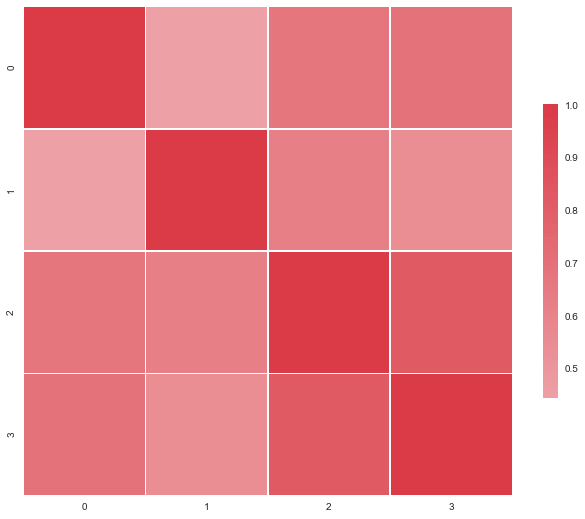

In [14]:
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(COR, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})

plt.savefig("plot-application-covariance.png", dpi = 100, bbox_inches ="tight")

plt.show()

## The model

Stock price evolution is modelled by the following stochastic differential equation : $$ dS(t) = \mu dS_t + \sigma S_t dB(t) $$ where $S$ is the asset price, $\mu$ is the drift, $\sigma$ is the volatility and $B$ is a Brownian motion (which can be thought as $dB(t) \hookrightarrow N(0, dt)$). Let $r$ be the risk-free rate. After using Ito's Lemma to get an expression of $d\text{log}S_t$, the solution is given by : $S(t) = S(0) \text{exp} ((r-\frac{1}{2}\sigma^2)t + \sigma \sqrt{t} N(0, 1) )$. In the case where we are studying a basket of $d$ assets, $S_{(i)}(t) = S_{(i)}(0) \text{exp} ((r-\frac{1}{2}\sigma_{(i)}^2)t + \sigma \sqrt{t} W_{(i)} )$ for $i \in \{0, ..., d-1\}$ where the vector $W$ = $(W_{(0)}, ..., W_{(d-1)})$ follows a multivariate normal distribution with mean $MU = (0, ..., 0)$ and with a covariance matrix $COR$ which is in fact the correlation matrix between assets.

In [15]:
# generate random (returns-)correlated assets

number = COV.shape[0]
assert(COV.shape[0] == COV.shape[1])
N = 500
W = stats.multivariate_normal(mean = [0 for i in range(number)], cov = COR).rvs(N)
t = 10 # days

X = []
r = 0.5/100

for i in range(number):
    X.append( C[i]*np.exp( (r-1/2*COV[i][i])*t + np.sqrt(COV[i][i]) * np.sqrt(t) * W[:,i]) )

# print(X)


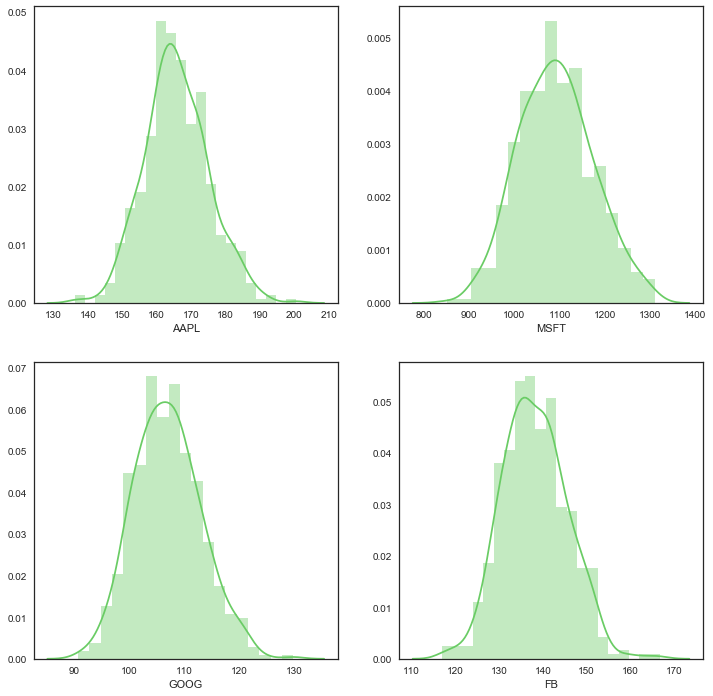

In [16]:
sns.set(style="white", palette="muted", color_codes=True)

# set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
# sns.despine(left=True)

plt.subplot(221)
sns.distplot(X[0], hist=True, color="g", kde_kws={"shade": False})
plt.xlabel(tickers[0])

plt.subplot(222)
sns.distplot(X[1], hist=True, color="g", kde_kws={"shade": False})
plt.xlabel(tickers[1])

plt.subplot(223)
sns.distplot(X[2], hist=True, color="g", kde_kws={"shade": False})
plt.xlabel(tickers[2])

plt.subplot(224)
sns.distplot(X[3], hist=True, color="g", kde_kws={"shade": False})
plt.xlabel(tickers[3])

plt.show()


## The problem

We want to calculate the payoff of a basket option : $$ \mathbb{E}_P \Big( f(S(T)) \Big) = \int f(s) p(s) ds $$ where for example $f(x) = \text{max} ( \sum_{i = 1}^{d} \alpha_{(i)} x_{(i)} - K, 0) $ with $K = \sum_{i = 1}^{d} \alpha_{(i)} S_{(i)}(0) $.

The idea is to approximate this expectancy by the one given by FWLSBQ : $$ \mathbb{E}_P \Big( f(S(T)) \Big) \simeq \sum_{i = 1}^{N} w_{(i)}^{BQ} f(S_{(i)}(T))) $$

## Application of FWLSBQ

In [17]:
# univariate and multivariate normal probability density function
univariatepdf = stats.norm.pdf
multivariatepdf = stats.multivariate_normal.pdf

In [18]:
# dimension = dim
dim = 4

In [19]:
# parameters of the probability density function p
mixmus = [
    np.zeros(dim)
]
mixsigmas = [
    COR
]
mixweights = [
    1.00
]

In [20]:
# sample according to p
def sample(mixmus, mixsigmas, mixweights, n):
    indexes = np.random.choice(len(mixweights), size=n, p=mixweights)
    L = mixmus[0].shape[0]
    A = np.zeros((n, L))
    for i, ix in enumerate(indexes):
        A[i, :] = stats.multivariate_normal.rvs(mixmus[ix], mixsigmas[ix])
    return A

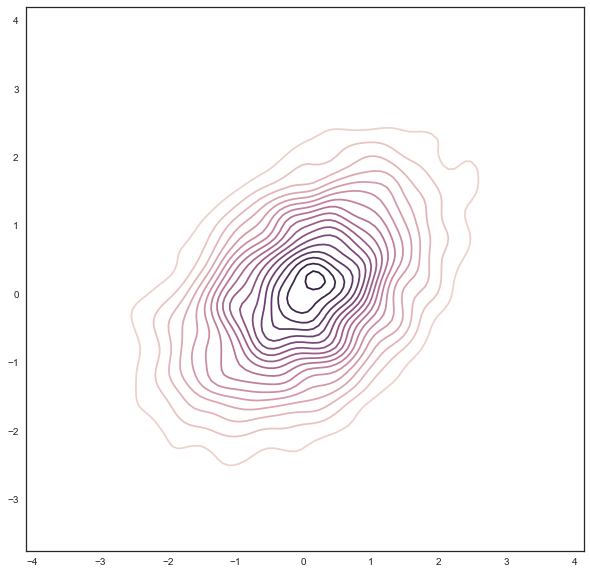

In [21]:
samplepoints = sample(mixmus, mixsigmas, mixweights, 4000)

X1 = samplepoints[:,0]
Y1 = samplepoints[:,1]

fig = plt.figure(figsize = (10, 10))
# create a cubehelix colormap to use with kdeplot
cmap = sns.cubehelix_palette(as_cmap=True)
# plot
sns.kdeplot(X1, Y1, cmap=cmap, shade=False, cut=2, n_levels=20)
plt.savefig("plot-application-kde.png", dpi = 100, bbox_inches ="tight")
plt.show()


In [22]:
# function f
def f(x):
    d = len(x)
    w = np.ones(d)/d
    t = 10
    r = 0.5/100
    S = 0
    for i in range(d):
        S += w[i] * C[i]*np.exp( (r-1/2*COV[i][i])*t +
                    np.sqrt(COV[i][i]) * np.sqrt(t) * x[i] )
    K = np.sum(w * C)
    return( np.max(S - K, 0) )
    # return( S - K )

In [23]:
# example, draw 6 points according to p
X = sample(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, n = 6)
for i in range(X.shape[0]):
    print(X[i,:], f(X[i,:]))

[-0.6598102  -0.39740975 -0.06483835 -0.33513189] 7.222174011067125
[ 0.5792911   0.84294871 -0.46299336  0.70527382] 37.00784896588107
[ 0.13395411  0.39105255 -0.09334099 -1.22502927] 23.29651421565518
[-0.6177292   0.45530138  0.38216349  0.68733866] 27.209128667648258
[1.63137139 1.04366725 2.33125772 2.3153863 ] 51.627155023244484
[0.80138536 0.45309647 1.64284204 0.62574231] 32.32033498447146


## Monte Carlo Integration

In [24]:
n = 5000 # number of points to draw at each iteration
m = 1 # number of iterations
I = []
for i in range(m):
    A = 0
    points = sample(mixmus, mixsigmas, mixweights, n = n)
    for j in range(n):
        weight = 1/n
        point = points[j,:]
        # print(point, f(point))
        A += weight*f(point)
    I.append(A)
print("Monte Carlo integration : ", sum(I)/len(I))

Monte Carlo integration :  17.856942054305442


## Frank-Wolfe Least Squares Bayesian Quadrature integration

In [25]:
n = 200 # number of points to draw
lambda_ = 1
sigma_ = 1

In [26]:
# reproducing kernel k (RKHS)
def kernel(a, b, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    return( lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim) * multivariatepdf(a.ravel(), b.ravel(), cov) )

In [27]:
# one-dimensional mean map kernel
def simplemeanmapkernel(x, mu, sigma, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    # np.linalg.det(sigma) = sigma
    # np.linalg.inv(sigma) = sigma
    return( lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim) * multivariatepdf(x.ravel(), mu.ravel(), sigma + cov) )
# two-dimensional mean map kernel
def mixturemeanmapkernel(x, mus, sigmas, mixweights, lambda_, sigma_):
    mixture = np.array([simplemeanmapkernel(x, mu1, sigma1, lambda_, sigma_) for mu1, sigma1 in zip(mus, sigmas)])
    return np.sum(mixweights * mixture)

In [28]:
# canonical feature map for a given x
def phi(x, lambda_, sigma_):
    def atom(a):
        return(kernel(a, x, lambda_, sigma_))
    return(atom)
# function to compute the successive g
def psi(rho, a, b):
    def g(x):
        return((1-rho) * a(x) + rho * b(x))
    return(g)

In [29]:
# define the model

# model = "FWBQ"
model = "FWLSBQ"

In [30]:
# start for rho, line-search
if model == "FWBQ":
    rho = [1/(i+1) for i in range(0, n)]
    print("model is FWBQ")
elif model == "FWLSBQ":
    rho = [1/(i+1) for i in range(0, 1)]
    print("model is FWLSBQ")
else:
    print("model has to be either FWLSBQ or FWBQ")

model is FWLSBQ


In [31]:
meanmapkernel = lambda x: mixturemeanmapkernel(x, mixmus, mixsigmas, mixweights, lambda_, sigma_)

In [32]:
# integral of the mean map kernel
def integralmeanmapkernel(mixmus, mixsigmas, mixweights, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    L = len(mixweights)
    c = lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim)
    a = 0
    for i in range(L):
        for j in range(L):
            a = a + mixweights[i] * mixweights[j] * multivariatepdf(x = mixmus[i].ravel(), mean = mixmus[j].ravel(), cov = mixsigmas[i] + mixsigmas[j] + cov)
    return(c * a)

In [33]:
# step 1 // FW (Frank-Wolfe) algorithm

# store information in a dictionary
dico = {} # dictionnary to store at each iteration : point(i), weight(i), g(i)
i = 1
print("{0} / {1}".format(i, n), end = '\r')
W = [np.nan]
for l in range(1, i+1):
    w = 1
    for j in range(l+1, i+1):
        w = w * (1-rho[j-1])
    w = w * rho[l-1]
    W.append(w)
X = sample(mixmus, mixsigmas, mixweights, n = 1) # draw the first point randomly
dico[i] = {"point" : X[0], "weight" : W}
dico[i]["function"] = phi(dico[i]["point"], lambda_, sigma_)
g = phi(dico[i]["point"], lambda_, sigma_)
dico[i]["g"] = g

for i in range(2, n+1):

    print("{0} / {1}".format(i, n), end = '\r')

    # step1 ) computing a new point

    # T is the function to minimize
    def T(x, i, kernel, meanmapkernel):
        s = 0
        for j in range(1, i):
            w = dico[i-1]["weight"][j]
            c = dico[j]["point"]
            s = s + ( w * kernel(x, c, lambda_, sigma_) )
        s = s - meanmapkernel(x)
        return(s)

    # samplepoints to find the minimum among them
    if i == 2:
        samplepoints1 = sample(mixmus, mixsigmas, mixweights, n = 5000)

    # start = clock()
    # find the minimum X
    Xmin = samplepoints1[0]
    Tmin = T(x = Xmin, i = i, kernel = kernel, meanmapkernel = meanmapkernel)
    for X in samplepoints1:
        t = T(x = X, i = i, kernel = kernel, meanmapkernel = meanmapkernel)
        if t < Tmin:
            Xmin = X
            Tmin = t
    X = Xmin
    # X = samplepoints1[np.argmin([T(x, i, kernel, meanmapkernel) for x in samplepoints1])]
    # end = clock()
    # print(end - start, "\n")

    # step 2 ) computing the weights for the next iteration

    if model == "FWLSBQ":
        # compute the matrix K
        K = np.zeros(shape = (i-1, i-1))
        for c in range(i-1):
            for d in range(i-1):
                Xc = dico[c+1]["point"]
                Xd = dico[d+1]["point"]
                K[c][d] = kernel(Xc, Xd, lambda_, sigma_)

        first = np.dot(np.dot([W[1:]], K), W[1:])
        second = 0
        weightedmeanmap = 0
        for r in range(1, i-1+1):
            point = dico[r]["point"] # point
            weight = W[r] # weight
            second += weight * kernel(point, X, lambda_, sigma_)
            weightedmeanmap += weight * meanmapkernel(point)
        numerator = first - second - weightedmeanmap + meanmapkernel(X)
        denominator = first - 2 * second + kernel(X, X, lambda_, sigma_)
        rho.append(float(numerator / denominator))

    W = [np.nan]
    for l in range(1, i+1):
        w = 1
        for j in range(l+1, i+1):
            w = w * (1-rho[j-1])
        w = w * rho[l-1]
        W.append(w)

    dico[i] = {"point" : X, "weight" : W}
    dico[i]["function"] = phi(dico[i]["point"], lambda_, sigma_)

    # step 3 ) computing the mean element
    g = psi(rho = rho[-1], a = g, b = dico[i]["function"])
    dico[i]["g"] = g


In [34]:
# step 2 // BQ (Bayesian Quadrature) algorithm

# compute the vector Z
Z = np.zeros(shape = (n, 1))
for i in range(n):
    Xi = dico[i+1]["point"]
    Z[i][0] = meanmapkernel(Xi)

# compute the matrix K
K = np.zeros(shape = (n, n))
for i in range(n):
    for j in range(n):
        Xi = dico[i+1]["point"]
        Xj = dico[j+1]["point"]
        K[i][j] = kernel(Xi, Xj, lambda_, sigma_)
# compute the inverse of the matrix K
INVK = np.linalg.inv(K)

# Frank-Wolfe weights
WFW = W[1:]
print("sum of Frank-Wolfe weights = ", sum(WFW))

# Bayesian Quadrature weights
WBQ = np.dot(Z.transpose(), INVK)[0]
print("sum of Bayesian Quadrature weights = ", sum(WBQ))


sum of Frank-Wolfe weights =  0.9999999999999997
sum of Bayesian Quadrature weights =  0.9094115539560326


In [35]:
# step 3 // posterior mean, equation (4) in the article

# compute the vector F
F = np.zeros(shape = (n, 1))
for i in range(n):
    Xi = dico[i+1]["point"]
    F[i][0] = f(Xi)

# compute the posterior mean
mean = np.float(np.dot(np.dot(Z.transpose(), INVK), F))
print(mean)

15.624086002121514


In [36]:
# step 4 // posterior variance, equation (5) in the article

variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
variance2 = np.float(np.dot(np.dot(Z.transpose(), INVK), Z))
variance = variance1 - variance2
print(variance)

0.0038326910024543137


In [37]:
selectedpoints = np.matrix(data = np.zeros(n*dim).reshape(n, dim))
i = 0
for x in dico.items():
    selectedpoints[i,:] = x[1]["point"]
    i = i+1

selectedpoints = np.array(selectedpoints)

# print(selectedpoints)

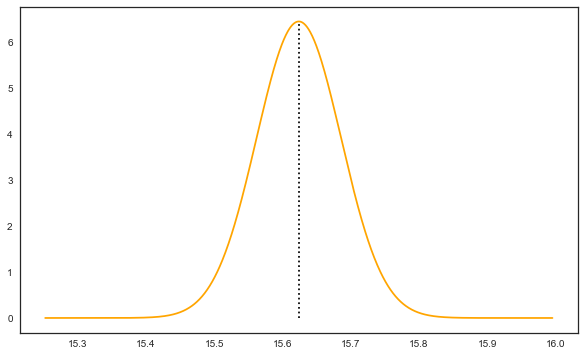

In [38]:
# step 5 // full posterior (normal distribution)

plt.rcParams["figure.figsize"] = (10, 6)
X_ = np.linspace(start = mean-6*np.sqrt(variance), stop = mean+6*np.sqrt(variance), num = 1000)
Y_ = univariatepdf(x = X_, loc = mean, scale = np.sqrt(variance))
plt.plot(X_, Y_, color = "orange")
plt.vlines(x = mean, ymin = 0, ymax = max(Y_), color = "black", linestyles = "dotted")
plt.show()


In [39]:
# summary

print(" Monte Carlo integration \t \t \t \t \t =", float(sum(I)/len(I)), "\n",
"Frank-Wolfe Line-Search integration \t \t \t \t =", float(np.float(np.dot(W[1:], F))), "\n",
"Frank-Wolfe Line-Search Bayesian Quadrature integration \t =", float(mean))


 Monte Carlo integration 	 	 	 	 	 = 17.856942054305442 
 Frank-Wolfe Line-Search integration 	 	 	 	 = 13.373124011732447 
 Frank-Wolfe Line-Search Bayesian Quadrature integration 	 = 15.624086002121514


In [40]:
# compute the vector G
G = np.zeros(shape = (n, n))
for i in range(n):
    print("{0} / {1}".format(i, n), end = '\r')
    gi = dico[i+1]["g"]
    for j in range(i+1):
        G[j,i] = gi(dico[j+1]["point"])
print(G[:4,:4])

[[1.         0.3479613  0.23988908 0.18540641]
 [0.         0.6520406  0.47197971 0.39344286]
 [0.         0.         0.36323614 0.28077184]
 [0.         0.         0.         0.27035271]]


In [41]:

# print(F.shape)
# print(Z.shape)
# print(K.shape)

start = 10

FWLS_mean = []
FWLSBQ_mean = []
FWLS_variance = []
FWLSBQ_variance = []

index = []
index.append(start)
x = start
while x < n:
    x += 5
    index.append(x)
    
I0 = index
    
for i in index:
    print("{0} / {1}".format(i, index[-1]), end = '\r')
    Gi = G[0:i,i-1].reshape(i, 1)
    Zi = Z[0:i,:]
    Fi = F[0:i,:]
    Ki = K[0:i,0:i]
    
    WeightsFW = dico[i]["weight"][1:]
    
    WeightsBQ = np.dot(Zi.transpose(), np.linalg.inv(Ki))
    
    MeanFW = np.float(np.dot(WeightsFW, Fi))
    
    MeanBQ = np.float(np.dot(WeightsBQ, Fi))
    
#     variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
#     variance2 = np.float(np.dot(WeightsFW, Gi))
#     variance = variance1 - variance2
    variance = np.sum(np.square(Gi - Zi))
    VarianceFW = abs(variance)
    
    variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
    variance2 = np.float(np.dot(WeightsBQ, Zi))
    variance = variance1 - variance2
    VarianceBQ = abs(variance)
    
    FWLS_mean.append(MeanFW)
    FWLSBQ_mean.append(MeanBQ)
    FWLS_variance.append(VarianceFW)
    FWLSBQ_variance.append(VarianceBQ)


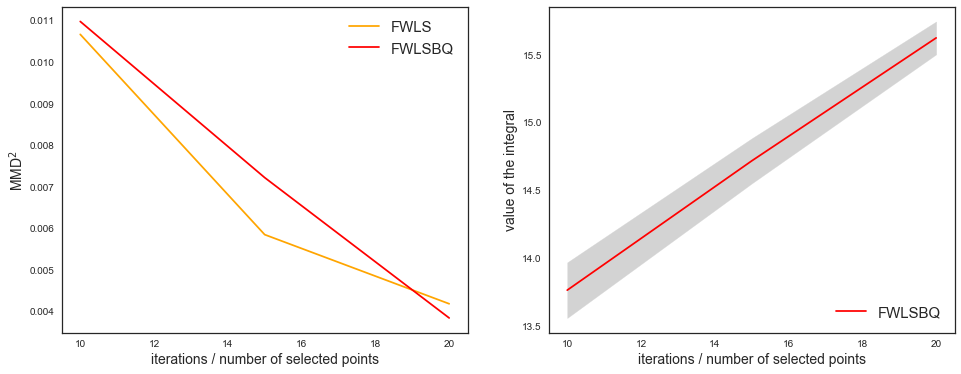

In [42]:
plt.rcParams["figure.figsize"] = (16, 6)

if model == "FWBQ":
    algo1 = "FW"
    algo2 = "FWBQ"
elif model == "FWLSBQ":
    algo1 = "FWLS"
    algo2 = "FWLSBQ"

plt.subplot(1,2,1)
X1 = I0
Y1 = FWLS_variance
Y2 = FWLSBQ_variance

line1, = plt.plot(X1, Y1, color = "orange", label = algo1)
line2, = plt.plot(X1, Y2, color = "red", label = algo2)
plt.xlabel(r"iterations / number of selected points", fontsize = 14)
plt.ylabel(r"MMD$^2$", fontsize = 14)
plt.legend(handles=[line1, line2], fontsize = 15, loc = 'upper right')

plt.subplot(1,2,2)
X0 = I0
Y0 = FWLSBQ_mean
Y01 = FWLSBQ_mean-1.96*np.sqrt(FWLSBQ_variance)
Y02 = FWLSBQ_mean+1.96*np.sqrt(FWLSBQ_variance)
line0, = plt.plot(X0, Y0, color = "red", label = algo2)
plt.fill_between(I0, Y01, Y02, color = "lightgrey")
plt.xlabel(r"iterations / number of selected points", fontsize = 14)
plt.ylabel(r"value of the integral", fontsize = 14)
plt.legend(handles=[line0], fontsize = 15, loc = 'lower right')

plt.savefig("plot-simualtion-mmdsquared-value-"+model+".png", dpi = 100, bbox_inches ="tight")

plt.show()
